In [14]:
import random
random.seed(42)
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.metrics import top_k_categorical_accuracy
from keras.losses import categorical_crossentropy
import tensorflow as tf
sess = tf.InteractiveSession()
from keras import backend as K
from keras.layers import Lambda

C:\Users\giaco\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# nDCG metric

In [4]:
#Discounted Cumulative Gain
def dcg(score): 
    res=[]
    for i in range((int(score.shape[0]))):
        #print(i)
        #print(score[i])
        rel_i = (score)[i]
        #print(rel_i)
        log = K.log(sess.run(tf.to_float(i+2)))
        #print(sess.run(log))
        #frac = K.tf.divide(rel_i,log)
        divResult = Lambda(lambda x: x[0]/x[1])([rel_i,log])

        res.append(sess.run(divResult))
    return np.sum(res)
#ideal discounted cumulative gain
def idcg(score_true):
    frac=[]
    y_sorted = sorted(sess.run(score_true),reverse=True)
    #print((y_sorted))
    for i in range(len(y_sorted)):
        num = 2**(y_sorted[i])-1
        #print(num)
        denom = np.log(i+2)
        #print (denom)
        frac.append(num/denom)
        #print(frac)
    return np.sum(frac)
#Normalized DCG
def nDCG(score,score_true):
    return dcg(score)/idcg(score_true)

In [5]:
train =  pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df = pd.concat((train,test))
df =df[["cosine_y","query","numWordsQuery","numWordsCV","numCommonWords","score"]]

X1 = train[["cosine_y","query","numWordsQuery","numWordsCV","numCommonWords"]]
y1 = train["score"]
X = X1.to_numpy()
y = y1.to_numpy()
y = y.flatten()
print(X.shape, y.shape)

(373, 5) (373,)


# NN in keras framework

In [19]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

# instantiate model
model = Sequential()

# input layer
model.add(Dense(64, input_dim=4, init='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#  hidden layer    
model.add(Dense(64, init='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

#  output layer
model.add(Dense(5, init='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()
model.compile(Adam(lr = 0.0001), loss="binary_crossentropy" , metrics=["accuracy"])

C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_dim=4, kernel_initializer="glorot_normal")`
  
C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="glorot_normal")`
  
C:\Users\giaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, kernel_initializer="glorot_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
__________

In [15]:
from sklearn.preprocessing import OneHotEncoder

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
c = np.array(df.score)
integer_encoded = c.reshape(len(c), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
y_onehot = pd.DataFrame(onehot_encoded,columns=["1","2","3","4","5"])

C:\Users\giaco\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [17]:
result = pd.concat([df, y_onehot], axis=1, join_axes=[df.index])
result.head()

,cosine_y,query,numWordsQuery,numWordsCV,numCommonWords,score,1,2,3,4,5
0,0.363,72,7,2435,1,3,0.0,0.0,1.0,0.0,0.0
1,0.483,71,10,619,3,3,0.0,0.0,1.0,0.0,0.0
2,0.474,71,10,977,3,1,1.0,0.0,0.0,0.0,0.0
3,0.358,70,2,8796,1,3,0.0,0.0,1.0,0.0,0.0
4,0.358,70,2,2558,1,1,1.0,0.0,0.0,0.0,0.0


In [38]:
grouped = result.groupby(by='query')

from numpy import argmax
from sklearn.preprocessing import LabelEncoder
data = [1,2,3,4,5]
values = np.array(data)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
ndcg=[]
for i,j in grouped:
    if len(j)>13: #do model for queries with at least 13 docs rated
        print("query idx:",i,"\ndocs evaluated:", len(j),"\n")
        n=int(70*len(j)/100)
        n2=int(30*len(j)/100)

        j=j.iloc[:n]
        test1 = j[-(n2):]
        test=(test1[["score"]])
        print("test shape",test1.shape)

        test1=test1[["cosine_y","numWordsQuery","numWordsCV","numCommonWords"]].to_numpy()
        y = j[['1','2','3','4','5']].to_numpy()
        #y = y_concat[:n]
        X = j[["cosine_y","numWordsQuery","numWordsCV","numCommonWords"]].to_numpy()
        X, y = shuffle(X, y)
        m=model.fit(X,y,validation_split=0.3, batch_size=1,epochs=5, shuffle=False, verbose=0)
        predictions = model.predict(test1, verbose=0)
        print("true scores:",np.array(test[["score"]]).flatten())
        # invert first example
        y_predicted=[]
        for p in predictions:
            y_predicted.append(argmax(p)+1)
        print("predicted scores:",y_predicted)
        vec1 = tf.constant(y_predicted,dtype=tf.float32)
        vec2 = tf.constant(np.array(test[["score"]]),dtype=tf.float32)
        print("metric nDCG:",nDCG(vec1,vec2))
        ndcg.append(nDCG(vec1,vec2))
        

query idx: 36 
docs evaluated: 14 

test shape (4, 11)
true scores: [1 5 1 2]
predicted scores: [5, 5, 5, 5]
metric nDCG: 0.37867296
query idx: 46 
docs evaluated: 22 

test shape (6, 11)
true scores: [2 1 3 2 4 3]
predicted scores: [1, 5, 5, 5, 5, 5]
metric nDCG: 0.4868099
query idx: 47 
docs evaluated: 15 

test shape (4, 11)
true scores: [5 5 4 4]
predicted scores: [1, 5, 1, 5]
metric nDCG: 0.10551983


In [56]:
from matplotlib import pyplot as plt 


Text(0.5, 1.0, 'NDCG for queries with num CV > 13')

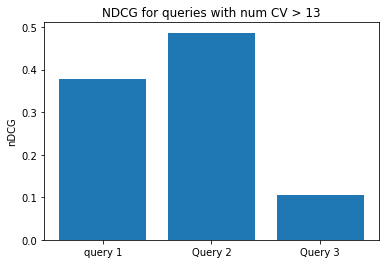

In [58]:
r=["query 1","Query 2","Query 3"]
plt.bar(r,ndcg)
plt.ylabel('nDCG')
plt.title("NDCG for queries with num CV > 13")